<a href="https://colab.research.google.com/github/IngErnestoAlvarez/terremoto_research/blob/main/TP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Configuración del entorno de desarrollo

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64" 

     |████████████████████████████████| 212.3MB 67kB/s 
     |████████████████████████████████| 204kB 18.0MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=f54b0215c4d88fffd25b0af11164918d3f20fddcc148a0e807a954d61f56b7f3
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 36.5 MB of archives.
After this 

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle, islice
%matplotlib inline

In [ ]:
train_label = pd.read_csv('train_labels.csv')
train_label = train_label.dropna().astype({'damage_grade': 'int32'})
train_label

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3
...,...,...
260596,688636,2
260597,669485,3
260598,602512,3
260599,151409,2


In [ ]:
train_values = pd.read_csv('train_values.csv',
                               usecols = ['building_id', 'geo_level_1_id', 'count_floors_pre_eq', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
                                          'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick',
                                          'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo'])
train_values = train_values.fillna(0)
train_values

,building_id,geo_level_1_id,count_floors_pre_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo
0,802906,6,2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,28830,8,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,94947,21,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,590882,22,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,201944,11,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
104898,719192,7,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
104899,849065,27,3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
104900,799099,11,4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
104901,173745,17,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


##Dinero perdido por región

In [ ]:
#Lista de precios
material_prices = pd.DataFrame({
    'material':['piso_adobe_mud',
                'piso_mud_mortar_stone',
                'piso_stone_flag',
                'piso_cement_mortar_stone',
                'piso_mud_mortar_brick',
                'piso_cement_mortar_brick',
                'piso_timber',
                'piso_bamboo'],
    'price':[2750,3250,750,4400,4550,3120,5000,3500]

})
material_prices = material_prices.set_index(['material'])
material_prices

,price
material,
piso_adobe_mud,2750
piso_mud_mortar_stone,3250
piso_stone_flag,750
piso_cement_mortar_stone,4400
piso_mud_mortar_brick,4550
piso_cement_mortar_brick,3120
piso_timber,5000
piso_bamboo,3500


Text(0.5, 1.0, 'Proporción número de edificaciones según grado de daño')

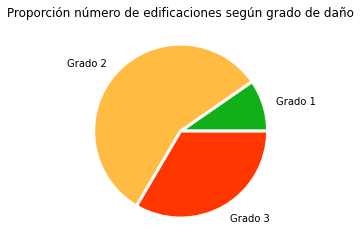

In [ ]:
plt.pie(proporcionDaño.cant_edificaciones, labels=['Grado 1', 'Grado 2', 'Grado 3'],
        labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
        colors=['#11b018','#ffbb42','#ff3600'])
plt.title('Proporción número de edificaciones según grado de daño')

In [ ]:
#Considero las construcciones que sufrieron un daño de grado 3 o 2,
#lo que representa perdidas considerables
edificiosConDaño = train_label.loc[train_label.damage_grade >= 2]
edificiosConDaño

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3
...,...,...
260596,688636,2
260597,669485,3
260598,602512,3
260599,151409,2


In [ ]:
#Ahora filtro el DF de train_values para considerar solo los edificios con
#un daño de grado 3 o 2
edificiosDestruidos = train_values.merge(edificiosConDaño, left_on='building_id', right_on='building_id', how='inner')
edificiosDestruidos

,building_id,geo_level_1_id,count_floors_pre_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,damage_grade
0,802906,6,2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,28830,8,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,94947,21,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,590882,22,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2
4,201944,11,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
94829,719192,7,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2
94830,849065,27,3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3
94831,799099,11,4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
94832,173745,17,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [ ]:
level1Serie = edificiosDestruidos.geo_level_1_id.value_counts()
level1 = level1Serie.to_frame().reset_index()
level1.columns = ['region', 'cant_edificios']
level1 = level1.set_index('region')
level1

,cant_edificios
region,
6,8995
17,8763
10,8431
8,7398
7,7304
21,5915
26,5777
20,5632
4,5591


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Edificios considerados por región')

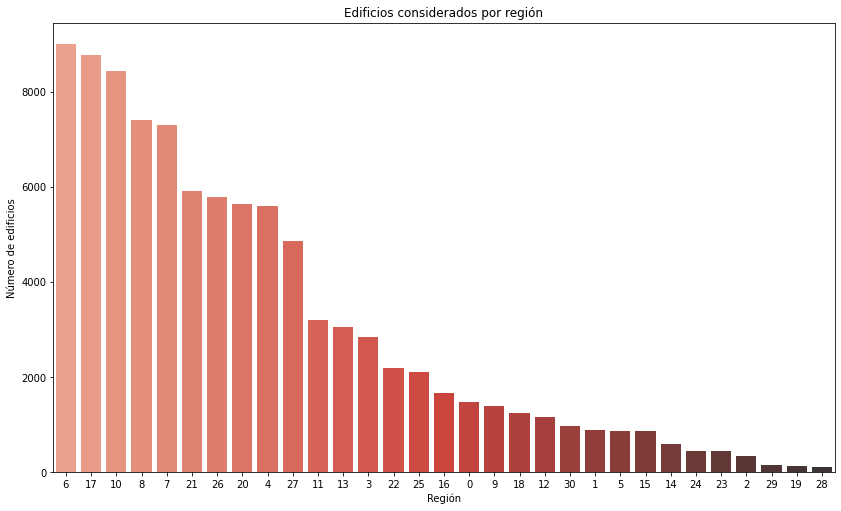

In [ ]:
a4_dims = (14, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
barGraph = sns.barplot(level1.index, level1.cant_edificios, palette='Reds_d', ax=ax, order=level1.index)
barGraph.set(xlabel="Región", ylabel = "Número de edificios")
barGraph.set_title("Edificios considerados por región")

In [ ]:
#Considero las 5 regiones (level1) con mayor cantidad de datos recopilados
regionsTop5 = edificiosDestruidos.merge(level1.head(5), left_on='geo_level_1_id', right_on='region', how='inner')
regionsTop5.geo_level_1_id.value_counts()

6     8995
17    8763
10    8431
8     7398
7     7304
Name: geo_level_1_id, dtype: int64

In [ ]:
regionsTop5

,building_id,geo_level_1_id,count_floors_pre_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,damage_grade,cant_edificios
0,802906,6,2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3,8995
1,633759,6,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,8995
2,157370,6,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,8995
3,33651,6,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3,8995
4,1005736,6,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,8995
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40886,835500,7,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,7304
40887,885721,7,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3,7304
40888,821110,7,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,7304
40889,626650,7,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,7304


In [ ]:
pisosPorMat = regionsTop5.loc[:,['building_id','geo_level_1_id']]

pisosPorMat['piso_adobe_mud'] = regionsTop5.count_floors_pre_eq * regionsTop5.has_superstructure_adobe_mud * (regionsTop5.damage_grade/3)
pisosPorMat['piso_mud_mortar_stone'] = regionsTop5.count_floors_pre_eq * regionsTop5.has_superstructure_mud_mortar_stone * (regionsTop5.damage_grade/3)
pisosPorMat['piso_stone_flag'] = regionsTop5.count_floors_pre_eq * regionsTop5.has_superstructure_stone_flag * (regionsTop5.damage_grade/3)
pisosPorMat['piso_cement_mortar_stone'] = regionsTop5.count_floors_pre_eq * regionsTop5.has_superstructure_cement_mortar_stone * (regionsTop5.damage_grade/3)
pisosPorMat['piso_mud_mortar_brick'] = regionsTop5.count_floors_pre_eq * regionsTop5.has_superstructure_mud_mortar_brick * (regionsTop5.damage_grade/3)
pisosPorMat['piso_cement_mortar_brick'] = regionsTop5.count_floors_pre_eq * regionsTop5.has_superstructure_cement_mortar_brick * (regionsTop5.damage_grade/3)
pisosPorMat['piso_timber'] = regionsTop5.count_floors_pre_eq * regionsTop5.has_superstructure_timber * (regionsTop5.damage_grade/3)
pisosPorMat['piso_bamboo'] = regionsTop5.count_floors_pre_eq * regionsTop5.has_superstructure_bamboo * (regionsTop5.damage_grade/3)

pisosPorMat

,building_id,geo_level_1_id,piso_adobe_mud,piso_mud_mortar_stone,piso_stone_flag,piso_cement_mortar_stone,piso_mud_mortar_brick,piso_cement_mortar_brick,piso_timber,piso_bamboo
0,802906,6,2.0,2.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1,633759,6,0.0,1.333333,0.0,0.0,0.0,0.0,0.000000,0.0
2,157370,6,0.0,1.333333,0.0,0.0,0.0,0.0,0.000000,0.0
3,33651,6,0.0,3.000000,0.0,0.0,0.0,0.0,0.000000,0.0
4,1005736,6,0.0,1.333333,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
40886,835500,7,0.0,1.333333,0.0,0.0,0.0,0.0,0.000000,0.0
40887,885721,7,0.0,2.000000,0.0,0.0,0.0,0.0,0.000000,0.0
40888,821110,7,0.0,1.333333,0.0,0.0,0.0,0.0,0.000000,0.0
40889,626650,7,0.0,1.333333,0.0,0.0,0.0,0.0,0.000000,0.0


In [ ]:
#Agrupo por region tal de obtener la cantidad de construcciones realizadas en cada material del set de datos
regionsTop5Grupped = pisosPorMat.groupby(['geo_level_1_id']).agg({'piso_adobe_mud':'sum', 'piso_mud_mortar_stone':'sum',
                                                                  'piso_stone_flag':'sum', 'piso_cement_mortar_stone':'sum',
                                                                  'piso_mud_mortar_brick':'sum', 'piso_cement_mortar_brick':'sum',
                                                                  'piso_timber':'sum', 'piso_bamboo':'sum'})
regionsTop5Grupped

,piso_adobe_mud,piso_mud_mortar_stone,piso_stone_flag,piso_cement_mortar_stone,piso_mud_mortar_brick,piso_cement_mortar_brick,piso_timber,piso_bamboo
geo_level_1_id,,,,,,,,
6,2542.000000,11845.000000,61.000000,46.666667,1234.000000,556.000000,1529.333333,207.000000
7,195.666667,10075.333333,715.666667,228.000000,518.666667,247.666667,2789.000000,160.666667
8,530.000000,13050.000000,373.666667,156.333333,195.333333,214.000000,2366.666667,766.000000
10,444.000000,13138.000000,552.333333,179.666667,113.666667,338.000000,4093.333333,195.666667
17,526.666667,18047.333333,1088.333333,262.333333,162.333333,500.666667,3269.000000,972.333333


In [ ]:
materialsQuantity = regionsTop5Grupped.stack().to_frame()
materialsQuantity = materialsQuantity.reset_index()
materialsQuantity.columns = ['region','material','cantidad']
materialsQuantity = materialsQuantity.pivot_table(index='material',columns='region', values='cantidad')
materialsQuantity

region,6,7,8,10,17
material,,,,,
piso_adobe_mud,2542.000000,195.666667,530.000000,444.000000,526.666667
piso_bamboo,207.000000,160.666667,766.000000,195.666667,972.333333
piso_cement_mortar_brick,556.000000,247.666667,214.000000,338.000000,500.666667
piso_cement_mortar_stone,46.666667,228.000000,156.333333,179.666667,262.333333
piso_mud_mortar_brick,1234.000000,518.666667,195.333333,113.666667,162.333333
piso_mud_mortar_stone,11845.000000,10075.333333,13050.000000,13138.000000,18047.333333
piso_stone_flag,61.000000,715.666667,373.666667,552.333333,1088.333333
piso_timber,1529.333333,2789.000000,2366.666667,4093.333333,3269.000000


In [ ]:
material_costs = materialsQuantity.merge(material_prices, left_on='material', right_on='material', how='inner')
material_costs

,6,7,8,10,17,price
material,,,,,,
piso_adobe_mud,2542.000000,195.666667,530.000000,444.000000,526.666667,2750
piso_bamboo,207.000000,160.666667,766.000000,195.666667,972.333333,3500
piso_cement_mortar_brick,556.000000,247.666667,214.000000,338.000000,500.666667,3120
piso_cement_mortar_stone,46.666667,228.000000,156.333333,179.666667,262.333333,4400
piso_mud_mortar_brick,1234.000000,518.666667,195.333333,113.666667,162.333333,4550
piso_mud_mortar_stone,11845.000000,10075.333333,13050.000000,13138.000000,18047.333333,3250
piso_stone_flag,61.000000,715.666667,373.666667,552.333333,1088.333333,750
piso_timber,1529.333333,2789.000000,2366.666667,4093.333333,3269.000000,5000


In [ ]:
#Calculo la cantidad de dinero que se gasto en cada material para cada region
material_costs[6] = material_costs[6]*material_costs.price
material_costs[7] = material_costs[7]*material_costs.price
material_costs[8] = material_costs[8]*material_costs.price
material_costs[10] = material_costs[10]*material_costs.price
material_costs[17] = material_costs[17]*material_costs.price
material_costs = material_costs.iloc[:,:5]
material_costs

,6,7,8,10,17
material,,,,,
piso_adobe_mud,6.990500e+06,5.380833e+05,1.457500e+06,1.221000e+06,1.448333e+06
piso_bamboo,7.245000e+05,5.623333e+05,2.681000e+06,6.848333e+05,3.403167e+06
piso_cement_mortar_brick,1.734720e+06,7.727200e+05,6.676800e+05,1.054560e+06,1.562080e+06
piso_cement_mortar_stone,2.053333e+05,1.003200e+06,6.878667e+05,7.905333e+05,1.154267e+06
piso_mud_mortar_brick,5.614700e+06,2.359933e+06,8.887667e+05,5.171833e+05,7.386167e+05
piso_mud_mortar_stone,3.849625e+07,3.274483e+07,4.241250e+07,4.269850e+07,5.865383e+07
piso_stone_flag,4.575000e+04,5.367500e+05,2.802500e+05,4.142500e+05,8.162500e+05
piso_timber,7.646667e+06,1.394500e+07,1.183333e+07,2.046667e+07,1.634500e+07


In [ ]:
cols_newOrder = [6,17,10,8,7]
material_costs_newOrder = material_costs[cols_newOrder]
material_costs_newOrder

,6,17,10,8,7
material,,,,,
piso_adobe_mud,6.990500e+06,1.448333e+06,1.221000e+06,1.457500e+06,5.380833e+05
piso_bamboo,7.245000e+05,3.403167e+06,6.848333e+05,2.681000e+06,5.623333e+05
piso_cement_mortar_brick,1.734720e+06,1.562080e+06,1.054560e+06,6.676800e+05,7.727200e+05
piso_cement_mortar_stone,2.053333e+05,1.154267e+06,7.905333e+05,6.878667e+05,1.003200e+06
piso_mud_mortar_brick,5.614700e+06,7.386167e+05,5.171833e+05,8.887667e+05,2.359933e+06
piso_mud_mortar_stone,3.849625e+07,5.865383e+07,4.269850e+07,4.241250e+07,3.274483e+07
piso_stone_flag,4.575000e+04,8.162500e+05,4.142500e+05,2.802500e+05,5.367500e+05
piso_timber,7.646667e+06,1.634500e+07,2.046667e+07,1.183333e+07,1.394500e+07


In [ ]:
regionsSpends = material_costs_newOrder.sum().to_frame()
regionsSpends.columns = ['dinero_perdido']
regionsSpends

,dinero_perdido
6,6.145842e+07
17,8.412155e+07
10,6.784753e+07
8,6.090890e+07
7,5.246285e+07


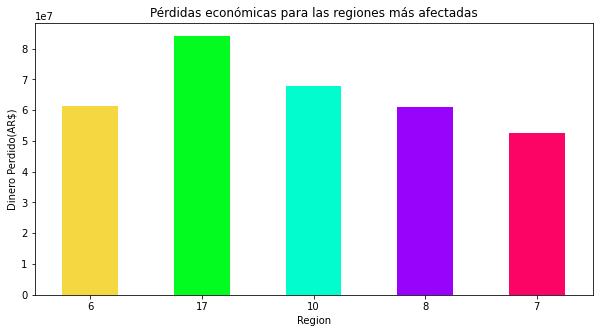

In [ ]:
regionsSpends['dinero_perdido'].plot.bar(title='Pérdidas económicas para las regiones más afectadas',
                                        linewidth=2, figsize=(10,5), color=['#f5d742', '#03fc20', '#03fcce', '#9803fc', '#fc0366'],
                                        ylabel='Dinero Perdido(AR$)', xlabel='Region', rot=0, y=["dinero_perdido"])

##Altura promedio para cada grado de daño

In [ ]:
#Agarro los 3 materiales mas utilizados a nivel nacional
#Filtro todos los edificios que usen al menos 1 de estos 3 mats
#Obtengo las 3 regiones con mayor cantidad de estos edificios
#Filtro todos los edificios que esten en alguna de estas 3 regiones
#Agrupo por region y por damage_grade, y calculo el promedio de cant de pisos

In [ ]:
edificiosMats = pd.DataFrame([('has_superstructure_adobe_mud', 0),('has_superstructure_mud_mortar_stone', 0),('has_superstructure_stone_flag', 0),
                             ('has_superstructure_cement_mortar_stone', 0),('has_superstructure_mud_mortar_brick', 0),('has_superstructure_cement_mortar_brick', 0),
                             ('has_superstructure_timber', 0),('has_superstructure_bamboo', 0)],
                            columns=['material', 'cant_edificios'])

edificiosMats.iloc[0,1] = train_values.has_superstructure_adobe_mud.sum()
edificiosMats.iloc[1,1] = train_values.has_superstructure_mud_mortar_stone.sum()
edificiosMats.iloc[2,1] = train_values.has_superstructure_stone_flag.sum()
edificiosMats.iloc[3,1] = train_values.has_superstructure_cement_mortar_stone.sum()
edificiosMats.iloc[4,1] = train_values.has_superstructure_mud_mortar_brick.sum()
edificiosMats.iloc[5,1] = train_values.has_superstructure_cement_mortar_brick.sum()
edificiosMats.iloc[6,1] = train_values.has_superstructure_timber.sum()
edificiosMats.iloc[7,1] = train_values.has_superstructure_bamboo.sum()

edificiosMats = edificiosMats.set_index(['material'])
edificiosMats

,cant_edificios
material,
has_superstructure_adobe_mud,9268.0
has_superstructure_mud_mortar_stone,79939.0
has_superstructure_stone_flag,3593.0
has_superstructure_cement_mortar_stone,1907.0
has_superstructure_mud_mortar_brick,7060.0
has_superstructure_cement_mortar_brick,7975.0
has_superstructure_timber,26681.0
has_superstructure_bamboo,8889.0


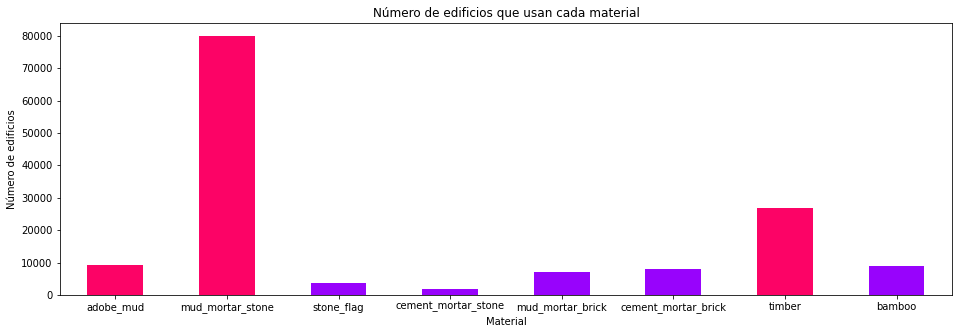

In [ ]:
#Acomodo el DFF para graficarlo correctamente
newIdx = ['adobe_mud', 'mud_mortar_stone', 'stone_flag', 'cement_mortar_stone',
              'mud_mortar_brick', 'cement_mortar_brick', 'timber', 'bamboo']
edificiosMats_toGraph = edificiosMats.copy()
edificiosMats_toGraph.index = newIdx
edificiosMats_toGraph.cant_edificios.plot.bar(rot=0,figsize= (16,5), xlabel='Material',ylabel='Número de edificios',
                               title='Número de edificios que usan cada material',
                               color = ['#fc0366', '#fc0366', '#9803fc', '#9803fc', '#9803fc', '#9803fc', '#fc0366', '#9803fc'])

In [ ]:
matsTop3 = edificiosMats.cant_edificios.nlargest(3).to_frame()
matsTop3

,cant_edificios
material,
has_superstructure_mud_mortar_stone,79939.0
has_superstructure_timber,26681.0
has_superstructure_adobe_mud,9268.0


In [ ]:
#Filtro todos los edificios que usen al menos 1 de estos 3 mats
edificiosFiltrados = train_values.query(matsTop3.index[0]+'==1 | '+matsTop3.index[1]+ '==1 | '+matsTop3.index[2]+'==1')
edificiosFiltrados

,building_id,geo_level_1_id,count_floors_pre_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo
0,802906,6,2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,28830,8,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,94947,21,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,590882,22,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,201944,11,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
104897,887728,20,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
104898,719192,7,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
104899,849065,27,3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
104900,799099,11,4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
regionesDatos = edificiosFiltrados.geo_level_1_id.value_counts().to_frame()
regionesDatos.columns = ['cant_edificios']
regionesDatos

,cant_edificios
17,8335
6,8327
10,8088
8,7137
7,6809
20,6177
26,6137
21,5859
4,5687
13,3827


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Edificios considerados por región')

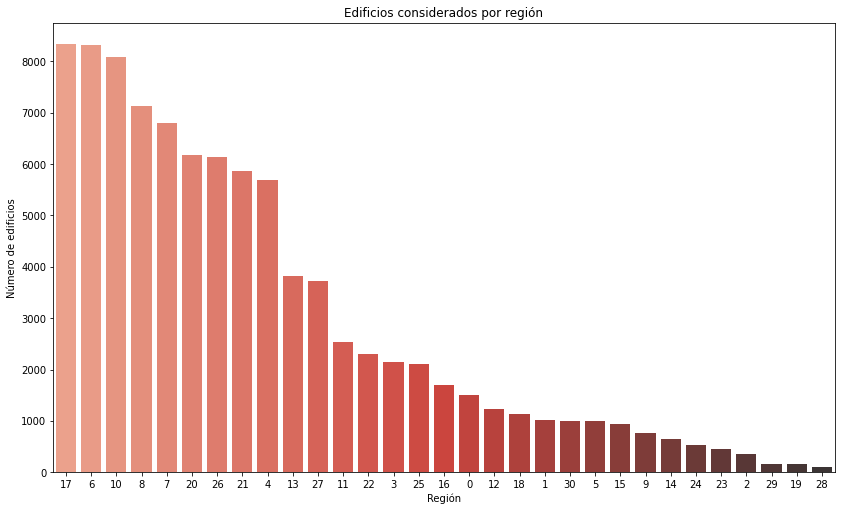

In [ ]:
a4_dims = (14, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
barGraph = sns.barplot(regionesDatos.index, regionesDatos.cant_edificios, palette='Reds_d', ax=ax, order=regionesDatos.index)
barGraph.set(xlabel="Región", ylabel = "Número de edificios")
barGraph.set_title("Edificios considerados por región")

In [ ]:
#Obtengo las 3 regiones con mayor cantidad de estos edificios
regionesConMasDatos = edificiosFiltrados.geo_level_1_id.value_counts().nlargest(3)
regionesConMasDatos = regionesConMasDatos.to_frame().reset_index()
regionesConMasDatos.columns = ['region', 'datos']
regionesConMasDatos

,region,datos
0,17,8335
1,6,8327
2,10,8088


In [ ]:
#Filtro todos los edificios que esten en alguna de estas 3 regiones 
#y agrego a cada edificio su damage_grade
regionsTop3 = edificiosFiltrados.merge(regionesConMasDatos, left_on='geo_level_1_id', right_on='region', how='inner')\
                                .merge(train_label, left_on='building_id', right_on='building_id', how='inner')
regionsTop3

,building_id,geo_level_1_id,count_floors_pre_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,region,datos,damage_grade
0,802906,6,2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6,8327,3
1,633759,6,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6,8327,2
2,157370,6,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6,8327,2
3,33651,6,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6,8327,3
4,1005736,6,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6,8327,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24745,881695,10,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10,8088,3
24746,864780,10,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10,8088,2
24747,585726,10,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10,8088,2
24748,514393,10,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10,8088,2


In [ ]:
#Agrupo por region y por damage_grade, y calculo el promedio de cant de pisos
groupped = regionsTop3.groupby(['geo_level_1_id','damage_grade'])
regions_and_damage = groupped.agg({'count_floors_pre_eq':['mean']})
regions_and_damage.columns = ['cant_pisos_promedio']
regions_and_damage

cant_pisos_promedio
geo_level_1_id damage_grade                     
6              1                        1.918519
               2                        2.180438
               3                        2.101044
10             1                        1.652174
               2                        2.109083
               3                        2.069983
17             1                        1.555556
               2                        2.362330
               3                        2.316204

In [ ]:
region6 = regions_and_damage.iloc[:3]
region6

cant_pisos_promedio
geo_level_1_id damage_grade                     
6              1                        1.918519
               2                        2.180438
               3                        2.101044

In [ ]:
region10 = regions_and_damage.iloc[3:6]
region10

cant_pisos_promedio
geo_level_1_id damage_grade                     
10             1                        1.652174
               2                        2.109083
               3                        2.069983

In [ ]:
region17 = regions_and_damage.iloc[6:9]
region17

cant_pisos_promedio
geo_level_1_id damage_grade                     
17             1                        1.555556
               2                        2.362330
               3                        2.316204

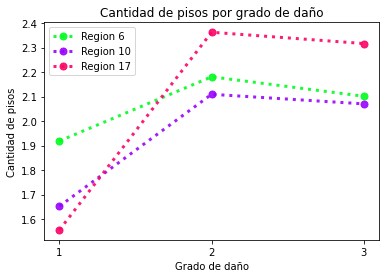

In [ ]:
plt.plot([1,2,3], region6.cant_pisos_promedio, marker='o', color='#03fc20', linewidth=3, alpha=0.9, label='Region 6', linestyle='dotted', markersize=7)
plt.plot([1,2,3], region10.cant_pisos_promedio, marker='o', color='#9803fc', linewidth=3, alpha=0.9, label='Region 10', linestyle='dotted', markersize=7)
plt.plot([1,2,3], region17.cant_pisos_promedio, marker='o', color='#fc0366', linewidth=3, alpha=0.9, label='Region 17', linestyle='dotted', markersize=7)

plt.legend()
plt.title('Cantidad de pisos por grado de daño')
plt.xticks([1,2,3])
plt.xlabel('Grado de daño')
plt.ylabel('Cantidad de pisos')
plt.show()